<a href="https://colab.research.google.com/github/mrchapagain/SocialNetworkAnalytics/blob/main/TwiteerDataAnalytics-singleClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tweeter Data Analytics

***Here I will cover:***
1. *Tweets from twetter user*
2. *Tweets # search by keywords*

***Libaries***

In [13]:
# Necessary libaries
from tweepy import OAuthHandler
from tweepy import API
import tweepy
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import time

# Libaries for sentiment analytics (NLP)
import matplotlib.pyplot as plt
import re
import spacy
import seaborn as sns

#Necessary information form tweet account
consumer_key='hYt37U1prLMj2LBfWaH3VfwAP'
consumer_secret='8sOKCBqlh0NLEByi3IjQ1mjlhTVhAtFzoOLqU9w5vn0qjmdAR1'
access_token='14970816-bxUWKHaeQvNpVP7nNzgOwWe2Sa3dsLAposBrhuhsg'
access_token_secret='nqioC9WEH7XFXpMU6KxmKuplZ4SIwmcgKAUzQYc1E2bXo'

#Tweepy authentication
auth = OAuthHandler(consumer_key, consumer_secret) # Consumer key authentication
auth.set_access_token(access_token, access_token_secret) # Access key authentication
api = API(auth)  # Set up the API with the authentication handler
api.me().screen_name  # just check if it is working

##Tweets from user
# Function to obtain tweet from specific user account
def tweets_by_user(user):
  limit=300
  tweets_obj= tweepy.Cursor(api.user_timeline, screen_name=user, count=200, tweet_mode="extended").items(limit)
  
  # Create Data Frame
  columns= ['Tweets', 'Likes', 'Time', 'User']
  tweets = []
  for i in tweets_obj:
    tweets.append([i.full_text, i.favorite_count, i.created_at, i.user.screen_name])

  df_by_id= pd.DataFrame(tweets, columns=columns)
  df_by_id['Time']=df_by_id['Time'].apply(lambda x: x.strftime('%Y-%m-%d'))

  #now lets make only tweets thats has not Re-Tweeted!
  df_by_id= df_by_id[~df_by_id.Tweets.str.contains("RT")].set_index('Tweets')
  
  return df_by_id

In [14]:
# Enter the Tweeter user-Id and see the data 
tweeter_id= input("Type Tweter-id which is after @, fx DRNyheder for DR News: ") # fxDRNyheder
df_user_tweet= tweets_by_user(tweeter_id)

df_user_tweet.head()

# Top most liked tweets
mostlike_df_user_tweet= df_user_tweet.loc[df_user_tweet.Likes.nlargest(10).index]
mostlike_df_user_tweet.head()

Type Tweter-id which is after @, fx DRNyheder for DR News: DRNyheder


,Likes,Time,User
Tweets,,,
"@AndersTTang Vi beklager, at der kom private detaljer ud i interviewet. Det skete live med en kilde, som lige havde oplevet noget forfærdeligt. Vi forsøger at blive klogere på, hvad der er sket i Field's, men gør alt, hvad vi kan for, at det sker uden, at vi får øjenvidner på, som i chok",120,2022-07-03,DRNyheder
Enhedslisten kalder manglende psykiatriplan for løftebrud https://t.co/0F5MQWdmJp https://t.co/9riXWJAvjp,104,2022-07-06,DRNyheder
Støttepartier tøver med at lade uvildige advokater vurdere minkrapport: 'Kan bedst betegnes som hykleri' https://t.co/Ry9EjxqRvm https://t.co/JAB32AD4Zn,89,2022-06-29,DRNyheder
Korrespondent tester billige tyske togbilletter: Jeg føler mig som formpresset dåsekød i en svedig menneskelasagne https://t.co/pRNkI7gtSa https://t.co/Bt1S9Ensga,88,2022-07-05,DRNyheder
Radikalt bagland presser partitop: Advokater skal vurdere om Mette Frederiksen skal for rigsret https://t.co/EUBhvTgKE1 https://t.co/2NjjCvg8YA,71,2022-07-01,DRNyheder


***Plot the word-colud***

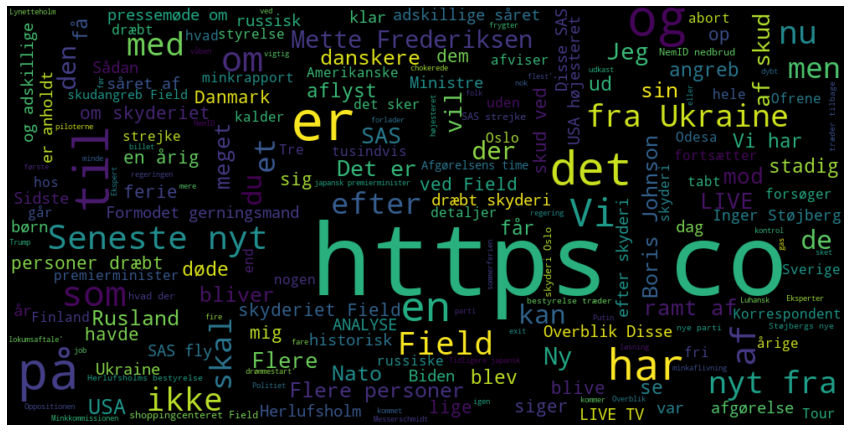

In [2]:
#Plot the word cloud
def wordcloud_plot(df_col):
  from wordcloud import WordCloud 
  allWords= ' '.join( [twts for twts in df_col] )
  wordCloud = WordCloud(width= 1000, height=500, random_state=21, max_font_size= 119).generate(allWords)
  plt.figure(figsize=(15,10))
  plt.imshow(wordCloud, interpolation = "bilinear")
  plt.axis('off')
  plt.show()

wordcloud_plot(df_user_tweet.index)

***Sentiment Analysis***

In [3]:
# Create a function to compute Negetive, Neutral and Positive analysis
import re
from textblob import TextBlob
def SentimentAnalysis(df):
  # first clean the text
  text= df['Tweets']

  def cleanText(text):
    text= re.sub(r'@[A-Za-z0-9]+', '',text) # Removed @mentions
    text= re.sub(r'#', '',text) # the '#' symbol
    text= re.sub(r':', '',text) # the ':' symbol
    text= re.sub(r'RT[\s]+', '',text) # Removed RT
    text= re.sub(r'https?:\/\/\s+', '',text) # Removed the hyper link
    return text

  #clean tweets
  df['Tweets']= df['Tweets'].apply(cleanText)

  #function to get the subjectivity
  def getSubjectivity(text=df['Tweets']):
    return TextBlob(text).sentiment.subjectivity
  #function to ge the polarity
  def getPolarity(text=df['Tweets']):
    return TextBlob(text).sentiment.polarity
  #Create to new columns
  df['Subjectivity']= df['Tweets'].apply(getSubjectivity)
  df['Polarity']= df['Tweets'].apply(getPolarity)

  # Function to sentiment
  def getAnalysis(score):
    if score < 0: return 'Negetive'
    elif score == 0: return 'Neutral'
    else: return 'Positive'

  df['Analysis']= df['Polarity'].apply(getAnalysis)
  #show the data
  return df

df_sentiment=SentimentAnalysis(mostlike_df_user_tweet.reset_index())
df_sentiment[['Tweets', 'Likes', 'Time', 'Analysis']].set_index('Tweets').head(1)

,Likes,Time,Analysis
Tweets,,,
"Vi beklager, at der kom private detaljer ud i interviewet. Det skete live med en kilde, som lige havde oplevet noget forfærdeligt. Vi forsøger at blive klogere på, hvad der er sket i Field's, men gør alt, hvad vi kan for, at det sker uden, at vi får øjenvidner på, som i chok",120,2022-07-03,Positive


***Plotting the Analytics***

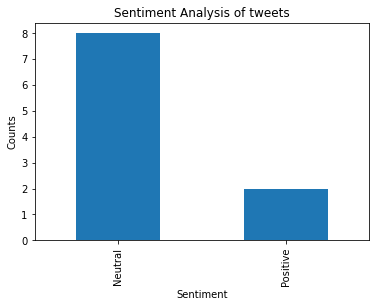

In [4]:
# Plot and visualize the counts
def sentiment_plot(df):
  plt.title('Sentiment Analysis of tweets')
  plt.xlabel('Sentiment')
  plt.ylabel('Counts')
  df['Analysis'].value_counts().plot(kind='bar')
  plt.show()

sentiment_plot(df_sentiment)


#2.  Tweets search by using Keywords or Hashtag

***Define function to scrap tweet by keywords***

In [11]:
# Obtaining tweet using keywords or Hastag
def tweets_by_keywords(keywords):
  limit=300

  tweets_obj= tweepy.Cursor(api.search, q=keywords, count=100, tweet_mode="extended").items(limit)
    # Create Data Frame
  columns= ['Tweets', 'Time', 'User']
  tweets = []
  for i in tweets_obj:
    tweets.append([i.full_text, i.created_at, i.user.screen_name])

  df= pd.DataFrame(tweets, columns=columns)
  df['Time']=df['Time'].apply(lambda x: x.strftime('%Y-%m-%d'))
  return df

#Get the data by typing keywords and look Sentiment Analytics
keywords=input('Type the word you want to search tweet by: ')
df_keywords= tweets_by_keywords(keywords)
SentimentAnalysis(df_keywords)[['Tweets',	'Time',	'User','Analysis']].set_index('Tweets').head()


Type the word you want to search tweet by: DRNyheder


,Time,User,Analysis
Tweets,,,
https//t.co/yVHiY6pkLq,2022-07-08,KalebLarsen17,Neutral
Skilsmissefædre ties ihjel❗️I dagspressen 😱 Alle vil helst blot lukke øjnene for den største diskrimination i 🇩🇰❗️😱 fordi Jaa gæt selv ❗️ lige,2022-07-08,CarstenLoffmann,Neutral
😪 men hvis alternativet er a-kraft. Så trods alt for en periode. Måske kan de arbejde med filtrene?,2022-07-08,Sweets19085151,Neutral
👊👊👊💪💪💪,2022-07-08,Thenastyforce,Neutral
dkmedier \nmsm all over this LEMMINGNATION -WORLD😬\n 🥀🥀🥀dkpol 🥀🥀🥀 https//t.co/gbw6yRKRnS,2022-07-08,svanemand,Neutral


***Disply word-cloud***

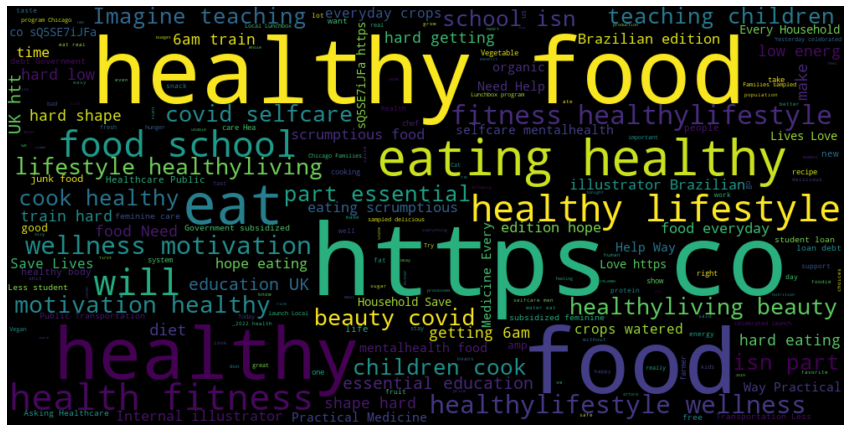

In [7]:
wordcloud_plot(df_keywords['Tweets'])

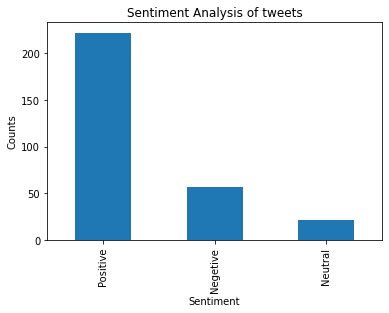

In [8]:
sentiment_plot(df_keywords)

# Visualization with text processing

In [9]:
import spacy.cli
spacy.cli.download("en_core_web_lg")
nlp = spacy.load('en_core_web_lg')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
# Split all the sentances and creat the list of sentence of from the tweet columns
list_of_sentences = [sentence for sentence in df.Tweets]

lines = []
for sentence in list_of_sentences:
  words = sentence.split()
  for w in words:
    lines.append(w)
print(lines[:20])

['Flere', 'personer', 'er', 'ramt', 'af', 'skud', 'i', "Field's", 'på', 'Amager', 'https//t.co/RnRnEULF4V', 'https//t.co/LlmrQmIBQC', 'Anmeldelse', 'om', 'skyderi', 'ved', 'shoppingcenteret', "Field's", 'https//t.co/7hlTyG2Kjs', 'https//t.co/dcZqK8uQnk']


In [ ]:
# Removing Punctuation by using Regular Expression (RegEx)
lines = [re.sub(r'[^A-Za-z0-9]+', '', x) for x in lines]

lines2= []

for word in lines:
  if word != '':
    lines2.append(word)

In [ ]:
# Stemming the words to their root
from nltk.stem.snowball import SnowballStemmer

s_stemmer = SnowballStemmer(language='english')

stem= []
for word in lines2:
  stem.append(s_stemmer.stem(word))

In [ ]:
# Removing all the stop words
stem2= []

for word in stem:
  if word not in nlp.Defaults.stop_words:
    stem2.append(word)

In [ ]:
df2 = pd.DataFrame(stem2)
df2 = df2[0].value_counts()
df2.head()

er     78
og     65
til    64
p      63
af     50
Name: 0, dtype: int64

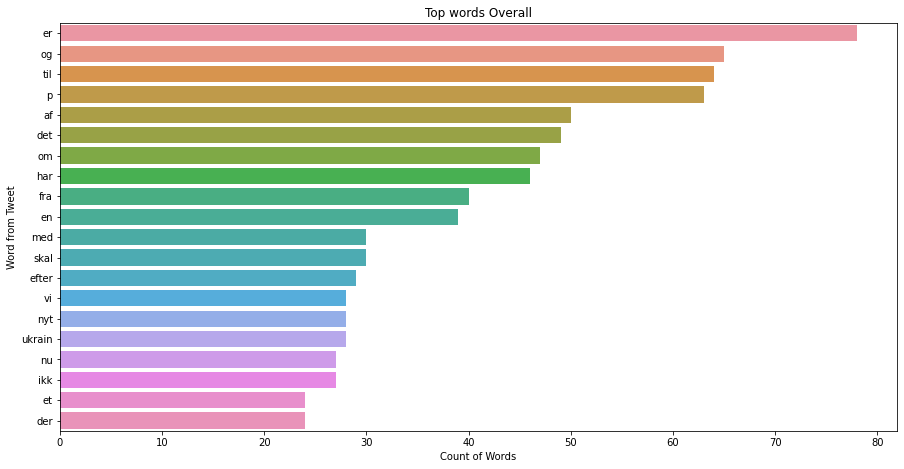

In [ ]:
# Visualization
df2= df2[:20,]
plt.figure(figsize=(15,7.5))
sns.barplot(df2.values, df2.index, alpha=1)
plt.title('Top words Overall')
plt.ylabel('Word from Tweet')
plt.xlabel('Count of Words')
plt.show()

In [ ]:
# Visualization for mentions organizations
def show_ents(doc):
  if doc.ents:
    for ent in doc.ents:
      print(ent.text + ' - ' + ent.label_ + ' - ' + str(spacy.explain(ent.label_)))

In [ ]:
str1 = " "
stem2 = str1.join(lines2)
stem2 = nlp(stem2)
label = [(X.text, X.label_) for X in stem2.ents]
df6 = pd.DataFrame(label, columns = ['Word', 'Entity'])
df7 = df6.where(df6['Entity'] == 'ORG')
df7 = df7['Word'].value_counts()

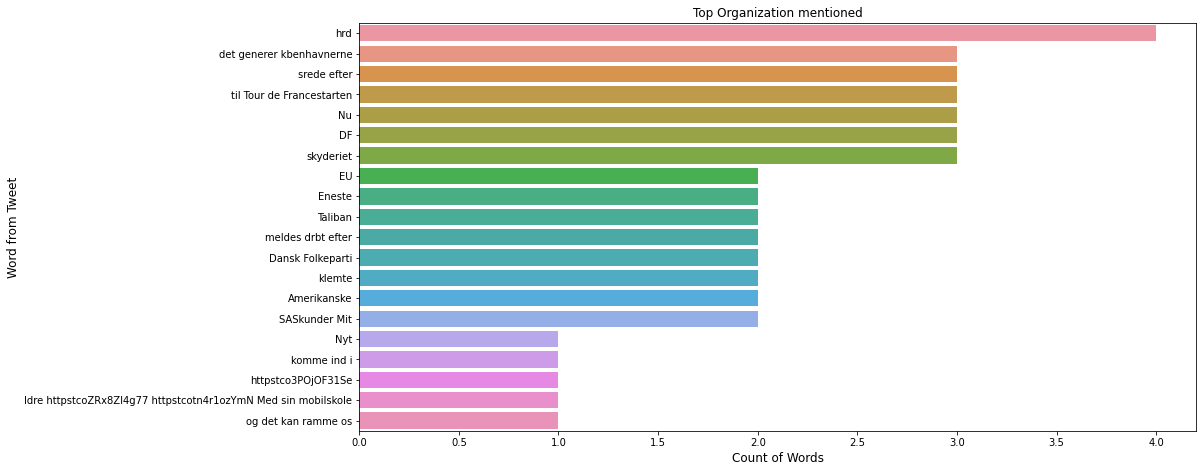

In [ ]:
# Visualization again
dfx= df7[:20, ]
plt.figure(figsize=(15,7.5))
sns.barplot(dfx.values, dfx.index, alpha=1)
plt.title('Top Organization mentioned')
plt.ylabel('Word from Tweet', fontsize=12)
plt.xlabel('Count of Words', fontsize=12)
plt.show()

In [ ]:
str1 = " "
stem2 = str1.join(lines2)
stem2 = nlp(stem2)
label = [(X.text, X.label_) for X in stem2.ents]
df6 = pd.DataFrame(label, columns = ['Word', 'Entity'])
df7 = df6.where(df6['Entity'] == 'PERSON')
df7 = df7['Word'].value_counts()

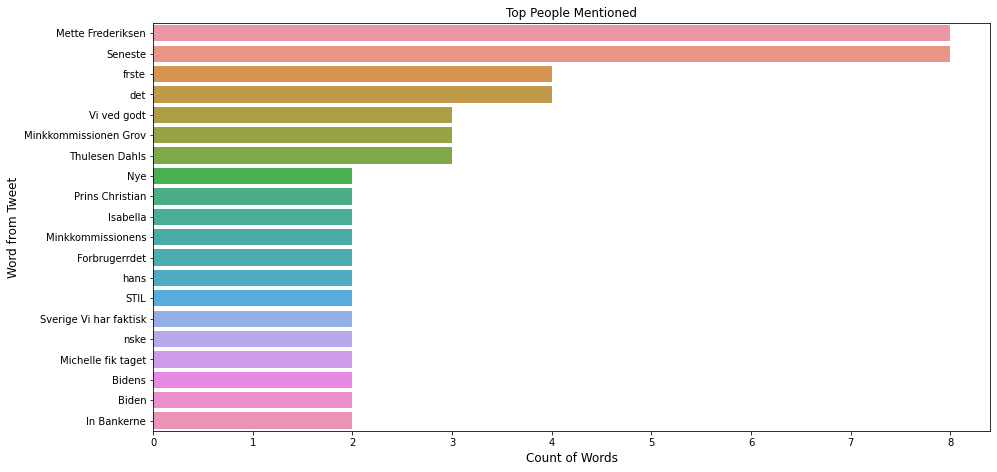

In [ ]:
# Visualization again
dfx= df7[:20, ]
plt.figure(figsize=(15,7.5))
sns.barplot(dfx.values, dfx.index, alpha=1)
plt.title('Top People Mentioned')
plt.ylabel('Word from Tweet', fontsize=12)
plt.xlabel('Count of Words', fontsize=12)
plt.show()

In [ ]:
!pip install tkinter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tkinter (from versions: none)
ERROR: No matching distribution found for tkinter


In [ ]:

# Import module
import tkinter as tk
from tkinter import filedialog
from tkinter import *
from PIL import ImageTk, Image
  
# Create object
root = tk.Tk()
  
# Adjust size
root.geometry( "200x200" )
  
# Change the label text
def show():
    label.config( text = clicked.get() )
  
# Dropdown menu options
options = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday"
]
  
# datatype of menu text
clicked = StringVar()
  
# initial menu text
clicked.set( "Monday" )
  
# Create Dropdown menu
drop = OptionMenu( root , clicked , *options )
drop.pack()
  
# Create button, it will change label text
button = Button( root , text = "click Me" , command = show ).pack()
  
# Create Label
label = Label( root , text = " " )
label.pack()
  
# Execute tkinter
root.mainloop()

TclError: ignored